### Import the Libraries

In [9]:
import os
import math
import pandas as pd
import numpy as np

import librosa
import librosa.display

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow.keras as keras
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.python.keras import regularizers

data_path = '../../audioaudio_data_MFCC/audio_output.npz'

### Load and prepare the data

In [10]:
def load_data (dataset_path, data1 = 'mfcc', data2 = 'labels'):
    
    np_file = np.load(dataset_path)
    
    return np_file[data1], np_file[data2]

In [11]:
def prepare_datasets(data_path, test_size, validation_size):
    
    # load data
    X, y = load_data(data_path, 'mfcc', 'labels')
    
    # create train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    
    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, 
                                                                    y_train, 
                                                                    test_size=validation_size)
    
    
    X_train = X_train[..., np.newaxis] # 4d array -> (num_samples, 130, 13, 1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

In [13]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets('../../audio/audio_data_MFCC/audio_output.npz', 0.25, 0.2)

### Define and build the model

In [14]:
### Import the necessary layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten

In [15]:
def build_model(input_shape):

    model = Sequential()

    # 1st Convulational Layer
    model.add(Conv2D(64, (5, 5), activation='relu', input_shape = input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 2nd Convulational Layer
    model.add(Conv2D(64, (3, 3), activation ='relu'))
    model.add(MaxPooling2D((3, 3), strides = (2, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    
    # 3rd Convulational Layer
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    
    # Flatten the output
    model.add(keras.layers.Flatten())
    
    # Feed it to the dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.25))

    # Output Layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [16]:
X_train.shape

(3595, 216, 13, 1)

### Build and Compile The Model

In [17]:
# Build the CNN
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

In [18]:
# Begin Compiling
optimizer = keras.optimizers.Adam(learning_rate = 0.00015)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Add in an early stop to avoid overtraining

In [19]:
early_stop = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=25)

In [20]:
history = model.fit(X_train, 
          y_train, 
          validation_data = (X_validation, y_validation), 
          batch_size = 64, 
          epochs = 100,
          callbacks = [early_stop]         
          )

Epoch 1/100
57/57 [==============================] - 10s 160ms/step - loss: 2.9619 - accuracy: 0.1480 - val_loss: 3.4841 - val_accuracy: 0.2180
Epoch 2/100
57/57 [==============================] - 9s 150ms/step - loss: 1.9846 - accuracy: 0.3298 - val_loss: 1.7867 - val_accuracy: 0.3860
Epoch 3/100
57/57 [==============================] - 9s 150ms/step - loss: 1.7450 - accuracy: 0.3884 - val_loss: 1.4824 - val_accuracy: 0.4727
Epoch 4/100
57/57 [==============================] - 8s 149ms/step - loss: 1.5795 - accuracy: 0.4360 - val_loss: 1.3293 - val_accuracy: 0.5261
Epoch 5/100
57/57 [==============================] - 9s 152ms/step - loss: 1.4588 - accuracy: 0.4717 - val_loss: 1.2743 - val_accuracy: 0.5417
Epoch 6/100
57/57 [==============================] - 8s 149ms/step - loss: 1.3336 - accuracy: 0.5246 - val_loss: 1.2515 - val_accuracy: 0.5373
Epoch 7/100
57/57 [==============================] - 9s 150ms/step - loss: 1.2762 - accuracy: 0.5381 - val_loss: 1.2127 - val_accuracy: 0.557

In [21]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

47/47 [==============================] - 1s 17ms/step - loss: 0.7840 - accuracy: 0.7263


### Plot

In [22]:
def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Eval")

    plt.show()

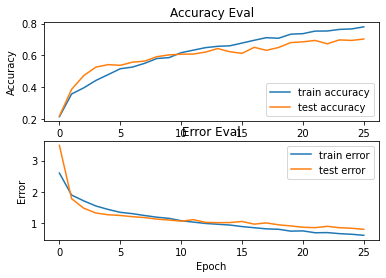

In [23]:
plot_history(history)

### Predict

In [24]:
predictions = model.predict(X_test, verbose = 1)

47/47 [==============================] - 1s 18ms/step


### Confusion Matrix

In [25]:
### Check the number of predicted values in each class, and append it to the labels_pred list
labels_pred = []
for i in range(10):
    
    print(f'{i}: {sum([1 for prediction in predictions if np.argmax(prediction) == i]) / 1000}')
    labels_pred.append(sum([1 for prediction in predictions if np.argmax(prediction) == i]) / 1000)

0: 0.137
1: 0.095
2: 0.2
3: 0.191
4: 0.122
5: 0.18
6: 0.127
7: 0.149
8: 0.13
9: 0.167


In [26]:
### Create a genre list 
genre_list = ['jazz:', 'reggae:', 'rock:', 'blues:', 'hiphop:', 'country:', 'metal:', 'classical:', 'disco:', 'pop:']


# Zip the results together
results = list(zip(genre_list, labels_pred))

# Sort them by second index
results = sorted(results, key = lambda x: x[1], reverse = True)

# Display the results of the predictionsfor i in results:
for i in results:
    print (' '.join(map(str, i)))

rock: 0.2
blues: 0.191
country: 0.18
pop: 0.167
classical: 0.149
jazz: 0.137
disco: 0.13
metal: 0.127
hiphop: 0.122
reggae: 0.095


### Save the Model

In [27]:
model.save('../models/cnn_genre_classifer_results.h5')

### Additional Prediction Stuff

In [28]:
def predict(model, X_prediction, y_prediction):
    
    X_prediction = X_prediction[np.newaxis, ...]
    
    # Plot predictions to a 2D Array
    predictions = model.predict(X_prediction)
    
    predicted_index = np.argmax(predictions, axis=1)
    
    
    print(f'Target: {y_prediction}, Predicted label: {predicted_index}')

In [29]:
X_prediction = X_test[100]
y_prediction = y_test[100]

In [30]:
pred = predict(model, X_prediction, y_prediction)

Target: 9, Predicted label: [9]
